In [177]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import bloscpack as bp

import sys
import os
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from annotation_utilities import *
from registration_utilities import *
from vis3d_utilities import *
from metadata import *
from data_manager_old import *

import time

import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
with open('colors.txt', 'r') as f:
    colors = {l[0]: np.r_[float(l[1]), float(l[2]), float(l[3])] for l in map(lambda x: x.split(), f.readlines())}

In [11]:
train_sample_scheme = 1
global_transform_scheme = 1
local_transform_scheme = 2

In [12]:
atlas_name = 'atlasV2'

In [13]:
paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', 'SNC', 'SNR', '3N', '4N',
                    'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']
structures = paired_structures + singular_structures

structure_colors = {n: np.random.randint(0, 255, (3,)) for n in structures}
# with open('colors.txt', 'r') as f:
#     colors = {l[0]: np.r_[float(l[1]), float(l[2]), float(l[3])] for l in map(lambda x: x.split(), f.readlines())}

In [14]:
structures_sided = sum([[n] if n in singular_structures else [convert_to_left_name(n), convert_to_right_name(n)]
                        for n in structures], [])

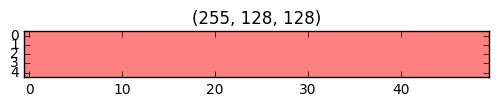

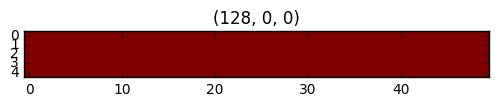

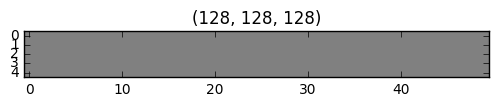

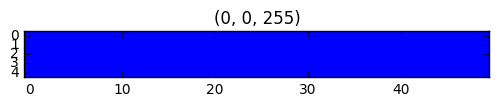

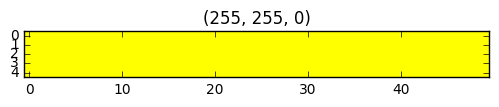

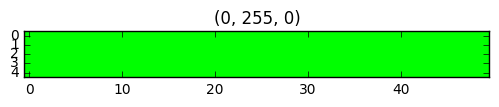

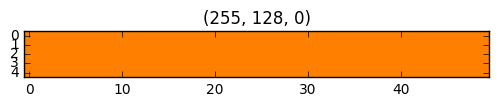

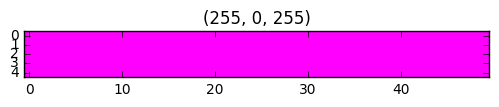

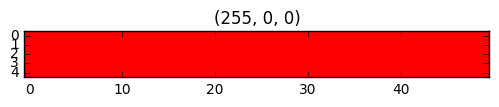

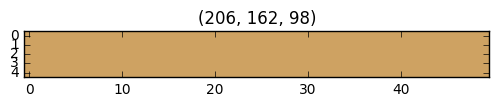

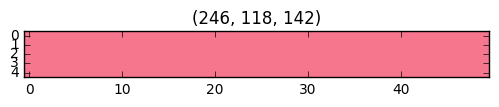

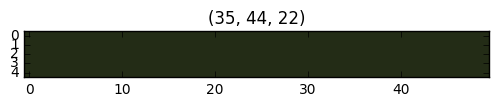

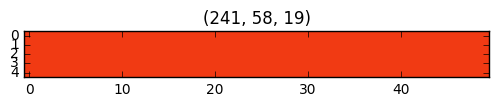

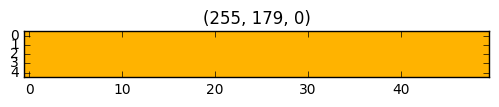

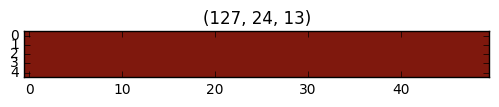

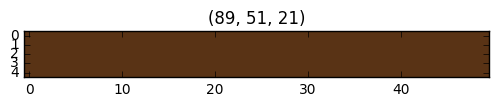

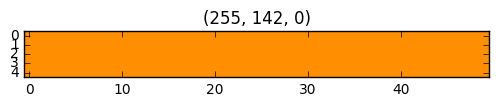

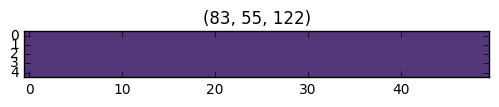

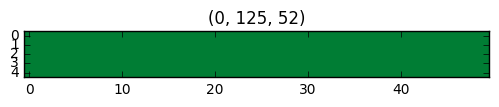

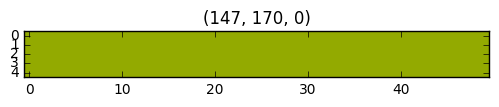

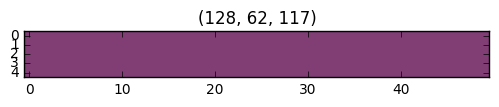

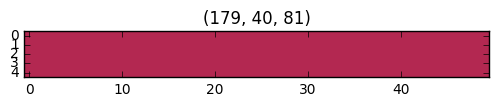

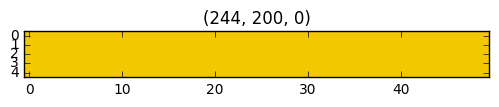

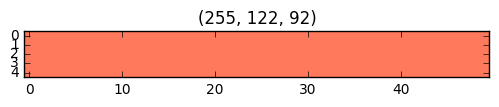

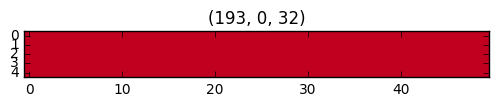

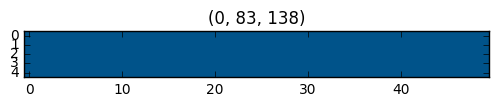

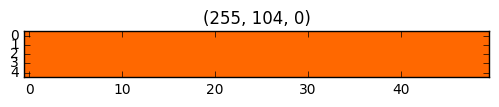

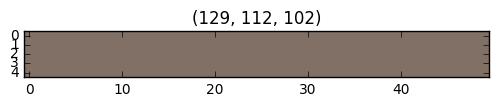

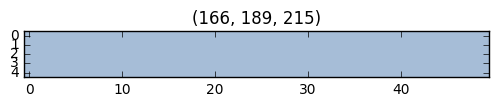

In [130]:
for c in high_contrast_colors:
    v = np.zeros((5,50,3))
    v[:, :] = np.array(c)/255.
    plt.imshow(v)
    plt.title(str(c))
    plt.show()

In [179]:
high_contrast_colors = np.random.permutation(high_contrast_colors)
map_name_s_to_color = {s: np.array(high_contrast_colors[i%len(high_contrast_colors)]) 
                     for i, s in enumerate(structures_sided) }

In [180]:
map_name_u_to_color = {s: np.array(high_contrast_colors[i%len(high_contrast_colors)]) 
                     for i, s in enumerate(structures) }

In [15]:
stack_colors = {n: np.array(high_contrast_colors[i%len(high_contrast_colors)]) for i, n in enumerate(all_stacks)}

# Genrate mesh for subject volume mapped back to atlas space

In [ ]:
# Render globally transformed atlas structures

# stack = 'MD590'
for stack in all_stacks:
    
    for name_s in structures_sided:
    # for name_s in ['12N']:

        print name_s

        reversed_volume = \
        DataManager.load_transformed_volume(stack_m=atlas_name, type_m='score', 
                                            stack_f=stack, type_f='score',
                                            downscale=32, 
                                            train_sample_scheme_f=train_sample_scheme,
                                            global_transform_scheme=global_transform_scheme,
                                            local_transform_scheme=local_transform_scheme,
                                            label=name_s, transitive='by')

    #     xmin, xmax, ymin, ymax, zmin, zmax = bbox_3d(reversed_volume)
    #     vol = reversed_volume[ymin:ymax+1, xmin:xmax+1, zmin:zmax+1]

    #     dense_vol = fill_sparse_score_volume(vol)

        t = time.time()

        polydata = volume_to_polydata(reversed_volume, origin=(0,0,0), num_simplify_iter=3, smooth=True, level=.5)

        sys.stderr.write('time: %.2f\n' % (time.time() - t))

        mesh_fn = DataManager.get_transformed_volume_mesh_filepath(stack_m=atlas_name, type_m='score', 
                                                             stack_f=stack, type_f='score', 
                                                             downscale=32,
                                                            train_sample_scheme_f=train_sample_scheme,
                                                            global_transform_scheme=global_transform_scheme,
                                                            local_transform_scheme=local_transform_scheme,
                                                            label=name_s, transitive='by')     

        save_mesh(polydata, mesh_fn)

# Load

In [25]:
# Load locally transformed atlas structure meshes

reversed_polydata_list = {}
for stack in all_nissl_stacks:
    reversed_polydata_list[stack] = DataManager.load_transformed_volume_meshes(stack_m=atlas_name, type_m='score', 
                                                         stack_f=stack, type_f='score', 
                                                         downscale=32,
                                                        train_sample_scheme_f=train_sample_scheme,
                                                        global_transform_scheme=global_transform_scheme,
                                                        local_transform_scheme=local_transform_scheme,
                                                        labels=structures_sided, transitive='by',
                                                      return_polydata_only=True)

In [26]:
ann_vol_xmin, ann_vol_xmax, ann_vol_ymin, ann_vol_ymax, ann_vol_zmin, ann_vol_zmax = \
DataManager.load_volume_bbox(stack='MD589', type='annotation', downscale=32)

print 'annotation volume bbox :', ann_vol_xmin, ann_vol_xmax, ann_vol_ymin, ann_vol_ymax, ann_vol_zmin, ann_vol_zmax

annotation volume bbox : 622 1042 155 502 127 503


In [27]:
shell_polydata = DataManager.load_shell_mesh(stack='MD589', downscale=32)

In [28]:
# Load atlas meshes

In [30]:
# Load canonical info
canonical_locations = read_dict_from_txt(os.path.join(MESH_ROOTDIR, atlas_name, 'canonical_locations.txt'), key_converter=str)
canonical_centroid = np.loadtxt(os.path.join(MESH_ROOTDIR, atlas_name, 'canonical_centroid.txt'))
canonical_normal = np.loadtxt(os.path.join(MESH_ROOTDIR, atlas_name, 'canonical_normal.txt'))

In [31]:
# Load atlas meshes

atlas_space_structure_meshes = DataManager.load_meshes(stack=atlas_name, labels=structures_sided)

In [32]:
# Load atlas structure surround meshes

atlas_space_structure_surround_meshes = DataManager.load_meshes(stack=atlas_name, \
                                        labels=[n + '_surround' for n in structures_sided])

In [33]:
# Create actors

all_atlas_structure_mesh_actors = {n: actor_mesh(polydata, (1.,1,1),
                                             wireframe=False,
                                                 opacity=.3,
                                              origin=canonical_centroid) 
                                   for n, polydata in atlas_space_structure_meshes.iteritems()}

all_atlas_structure_surround_mesh_actors = [actor_mesh(polydata, color=(0,1,0),
                                                      wireframe=True,
                                                      origin=canonical_centroid) 
                                            for n, polydata in atlas_space_structure_surround_meshes.iteritems()]
    
shell_actor = actor_mesh(shell_polydata, (1,1,1), opacity=.15, wireframe=False)

In [ ]:
# For yoav's

In [231]:
def map_name_to_opacity(name):
#     if name in ['7N_L', '7N_R', '5N_L', '5N_R', '12N', 'Pn_L', 'Pn_R', 'LC_L', 'LC_R', 'Amb_L', 'Amb_R',
#                'Tz_L', 'Tz_R', '3N_L', '3N_R', '4N_L', '4N_R', 'RMC_L', 'RMC_R', '10N_L', '10N_R']:
    if name in ['VLL_L', 'RMC_L', 'LRt_L']:
        opacity = .5
    else:
        opacity = 0.01
    return opacity

In [232]:
all_reversed_structure_actors = {st: [actor_mesh(p, 
                       wireframe=False, 
#                        color=structure_colors[convert_name_to_unsided(n)]/255., 
#                         color=(0,1,0), 
#                         color=stack_colors[st]/255.,
                        color=map_name_u_to_color[convert_to_original_name(n)]/255.,
                        opacity=map_name_to_opacity(n),
                      origin=(ann_vol_xmin, 
                              ann_vol_ymin, 
                              ann_vol_zmin))
                                      for n, p in ps.iteritems() if n not in outliers or st not in outliers[n]]
            for st, ps in reversed_polydata_list.iteritems()
                                if st in all_nissl_stacks}

In [233]:
launch_vtk(
#     all_atlas_structure_mesh_actors.values() + \
           [shell_actor] + \
           sum(all_reversed_structure_actors.values(), []))

In [150]:
all_reversed_structure_actors = {st: [actor_mesh(p, 
                       wireframe=False, 
#                        color=structure_colors[convert_name_to_unsided(n)]/255., 
#                         color=(0,1,0), 
                        color=stack_colors[st]/255.,
                       opacity=.3,
                      origin=(ann_vol_xmin, 
                              ann_vol_ymin, 
                              ann_vol_zmin))
                                      for n, p in ps.iteritems() if n not in outliers or st not in outliers[n]]
            for st, ps in reversed_polydata_list.iteritems()}

In [54]:
launch_vtk(all_atlas_structure_mesh_actors.values() + \
           [shell_actor] + \
           sum(all_reversed_structure_actors.values(), []))

In [37]:
outliers = read_dict_from_txt('/home/yuncong/Brain/outliers.txt', converter=str, key_converter=str)

In [55]:
# names_of_interest = ['7N_L', '7N_R', '5N_L', '5N_R', '12N', 'Tz_L', 'Tz_R', '7n_L', '7n_R', 'LRt_L', 'LRt_R',
#                     'Pn_L', 'Pn_R', 'SNR_L', 'SNR_R']

names_of_interest = ['7N_L']

# names_of_interest = [n for n in structures_sided \
#                      if '_L' not in n and \
#                      convert_name_to_unsided(n) not in ['AP', 'DC', 'Sp5O', 'Sp5I', 'Sp5C', 'RtTg', 'VCP', 'VCA']]


particular_reversed_structure_actors_all = {}

for name_s_interest in names_of_interest:

    if name_s_interest in outliers:
        print 'Outlier stack for %s:' % name_s_interest, outliers[name_s_interest]

    particular_reversed_structure_actors = [actor_mesh(p, 
                           wireframe=True, 
    #                        color=structure_colors[convert_name_to_unsided(n)]/255., 
    #                         color=(0,1,0), 
                            color=stack_colors[st]/255.,
                           opacity=1.,
                          origin=(ann_vol_xmin, 
                                  ann_vol_ymin, 
                                  ann_vol_zmin))
                for st, ps in reversed_polydata_list.iteritems() for n, p in ps.iteritems() 
                                            if n == name_s_interest and \
                                            (name_s_interest not in outliers or st not in outliers[name_s_interest])]
    
    particular_reversed_structure_actors_all[name_s_interest] = particular_reversed_structure_actors

Outlier stack for 7N_L: MD598


In [57]:
launch_vtk([all_atlas_structure_mesh_actors[n] for n in names_of_interest] + \
           [shell_actor] + \
           sum(particular_reversed_structure_actors_all.values(), []), init_angle='horizontal_topDown')

In [41]:
launch_vtk(all_atlas_structure_mesh_actors.values() + all_reversed_structure_actors['MD589'] + \
           [shell_actor])

NameError: name 'all_reversed_structure_actors' is not defined

In [119]:
launch_vtk(all_atlas_structure_mesh_actors.values() + sum(all_reversed_structure_actors.values(), []) + \
           [shell_actor])